In [4]:
# 1. 데이터 전처리 관련 모듈 import
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from scipy.stats import boxcox

# 2. 데이터 분할
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, cross_val_predict, cross_validate, StratifiedKFold

# 3. 사용할 알고리즘 import
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.inspection import PartialDependenceDisplay

from xgboost import XGBRegressor

# 4. 성능 평가
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error, root_mean_squared_log_error

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pickle
import shap
import datetime as dt
import joblib

def getScore(name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    rmsle = root_mean_squared_log_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f'{name}, r2: {r2:.3f}, mape: {mape:.3f}, rmse: {rmse:.3f}')

In [5]:
def convert_df(df_input):
    # VR Feed 관련 열: [118:152]
    df_input_vr_feed = df_input.iloc[:, 118:152]
    
    # 의미없는 맨 첫 열 제거하고 두번째 열을 column 이름으로 사용
    df_input_vr_feed.columns = df_input_vr_feed.iloc[0]
    df_input_vr_feed = df_input_vr_feed[1:].reset_index(drop=True)
    
    # 제거할 열: 0, 2, 5, 7,11, 13, 16, 17, 18, 19, (20 NC7은 포함) 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33 + SEDEX
    col_to_drop = df_input_vr_feed.columns[[0, 2, 5, 7,11, 13, 16, 17, 18, 19, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33]]
    df_input_vr_feed.drop(col_to_drop, axis=1, inplace=True)
    df_input_vr_feed.drop('SEDEX', axis=1, inplace=True)
    
    # df dtype 변경
    for col in df_input_vr_feed.columns:
        df_input_vr_feed[col] = df_input_vr_feed[col].astype('float64')
    
    # 결측치는 평균으로 채우기
    for col in df_input_vr_feed.columns:
        df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)
    
    # 위 df에 2024년 평균 운전 데이터를 merge
    # 먼저 2024년 평균 운전 데이터를 df로 구성
    df = pd.read_csv('df_58thtrial.csv')
    df['Datetime'] = df['Datetime'].astype('datetime64[ns]')
    df.set_index('Datetime', drop=True, inplace=True)
    df = df.loc[df.index.year == 2024]
    opavg2024_list = []
    for col in df.columns[:15]:
        opavg2024_list.append(df[col].mean())
    opavg2024_df = pd.merge(pd.DataFrame(df.columns[:15]), pd.DataFrame(opavg2024_list), left_index=True, right_index=True)
    opavg2024_df.columns = ['variable', 'avg']
    opavg2024_df_t = opavg2024_df.transpose()
    opavg2024_df_t.columns = opavg2024_df_t.iloc[0]
    opavg2024_df_t = opavg2024_df_t[1:].reset_index(drop=True)
    opavg2024_df_t_repeated = pd.DataFrame([opavg2024_df_t.iloc[0]] * len(df_input_vr_feed), columns=opavg2024_df_t.columns)
    opavg2024_df_t_repeated.reset_index(drop=True, inplace=True)
    
    df = pd.concat([opavg2024_df_t_repeated, df_input_vr_feed], axis=1)
    return df
    # 이후 scaler.pkl을 이용한 표준화, Ni, V에 대한 pca 및 ni, v 제거, vis100을 sqrt 변환해야 SHFT 예측 가능함

## 58th trial + SHFT 단위 변경(%>ppm)

In [6]:
df = pd.read_csv('./df_58thtrial.csv', index_col = 'Datetime')
df['SHFT_avg'] = df['SHFT_avg'] * 10000

In [7]:
# vis100 대신 sqrt(vis100) 사용
df['vis100_sqrt'] = np.sqrt(df['V(100) cSt.'])

# modeling - x 데이터로 V(100) 대신 sqrt v100
x = df.drop(['SHFT_avg', 'V(100) cSt.'], axis=1)
y = df['SHFT_avg']

# standard scaling - 최초 1회 수행
scaler = StandardScaler()
scaler.fit(x)  # Only fit on the training data
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)

# pca - 최초 1회 수행
pca = PCA(n_components=1)  # Keep one principal component
pca.fit(x_scaled[['Ni ppm', 'V ppm']])
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# scaler, pca 함수 pkl로 추출 - 최초 1회 수행
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')

# scaler, pca는 동일한 모델 사용
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca.pkl')
x_scaled = pd.DataFrame(scaler.transform(x), columns=x.columns)
x_pca = pca.transform(x_scaled[['Ni ppm', 'V ppm']])
x_scaled['Ni_V_PCA'] = x_pca
x_scaled.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# train/validation/test split
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y, test_size=0.4, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)
x_train_val = pd.concat([x_train, x_val])
y_train_val = pd.concat([y_train, y_val])

# model = linear regression
lr = LinearRegression()

# 1. cross validation을 통해 모델 성능 1차 확인
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
scores_lr = cross_val_score(lr, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("LR Cross-Validation Scores:", scores_lr)
print("LR CV Average Score:", scores_lr.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
lr.fit(x_train, y_train)
y_val_pred_lr = lr.predict(x_val)
getScore('lr_validation', y_val, y_val_pred_lr)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
lr.fit(x_train_val, y_train_val)
y_test_pred_lr = lr.predict(x_test)
getScore('lr_test', y_test, y_test_pred_lr)

# lr 모델 추출
joblib.dump(lr, 'lr.pkl')

LR Cross-Validation Scores: [0.52503121 0.54812075 0.36422019 0.58518039 0.42410031 0.49326127
 0.61453117 0.46461735 0.40556928 0.53565377]
LR CV Average Score: 0.4960285686653313
lr_validation, r2: 0.599, mape: 0.231, rmse: 115.045
lr_test, r2: 0.584, mape: 0.222, rmse: 132.321


['lr.pkl']

<Axes: xlabel='features'>

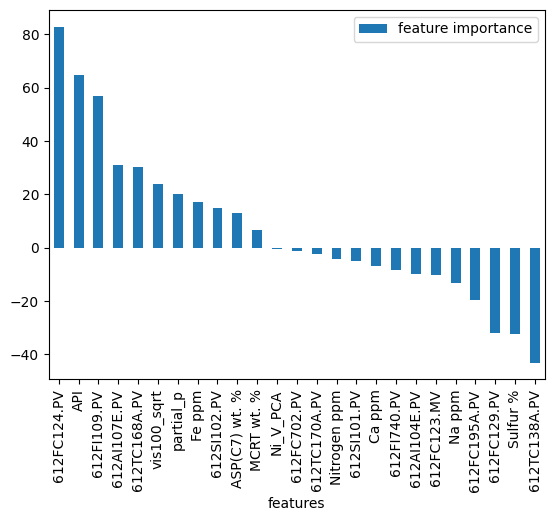

In [8]:
lr_importance = lr.coef_
fi_df_lr = pd.DataFrame({'features':x_scaled.columns, 'feature importance':lr_importance})
fi_df_lr.sort_values(by='feature importance',ascending=False).plot(kind='bar', x='features')

C:\Users\C17402\AppData\Local\Temp\ipykernel_2520\3813585595.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: xlabel='V(100) cSt.', ylabel='SHFT_avg'>

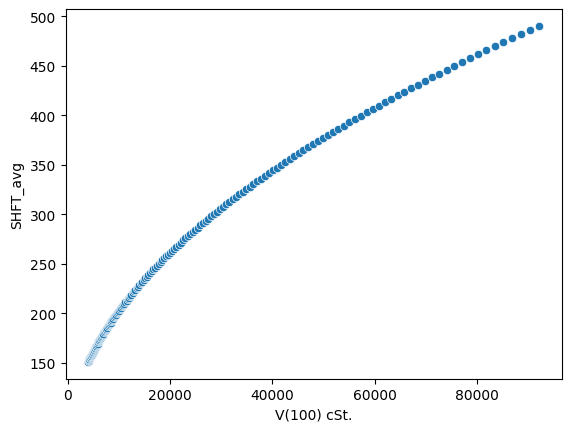

In [9]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - vis
# load original assay
df_assay = pd.read_csv('./Assay Summary_visco.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_sqrt 추가 후 vis100 제거
df_assay['vis100_sqrt'] = np.sqrt((df_assay['V(100) cSt.']))
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)

# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')

C:\Users\C17402\AppData\Local\Temp\ipykernel_2520\3813585595.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_input_vr_feed[col].fillna(df_input_vr_feed[col].mean(), inplace=True)


<Axes: xlabel='V(100) cSt.', ylabel='SHFT_avg'>

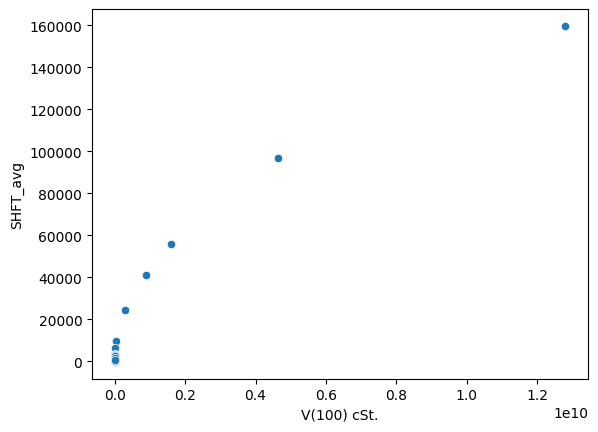

In [10]:
# 임의의 input file(assay)에 대해 df 변형 후 prediction까지 수행해보자 - original 
# load original assay
df_assay = pd.read_csv('./Assay Summary_original.csv', encoding='cp949')
# assay -> df 
df_assay = convert_df(df_assay)
df_assay_original = df_assay.copy()
df_assay_feedonly = df_assay_original.loc[:,'API':]

# df에서 vis100_sqrt 추가 후 vis100 제거
df_assay['vis100_sqrt'] = np.sqrt(df_assay['V(100) cSt.'])
df_assay.drop('V(100) cSt.', axis=1, inplace=True)

# scaling
scaler = joblib.load('scaler.pkl')
df_assay = pd.DataFrame(scaler.transform(df_assay), columns=x.columns)

# pca
pca = joblib.load('pca.pkl')
df_assay_pca = pca.transform(df_assay[['Ni ppm', 'V ppm']])
df_assay['Ni_V_PCA'] = df_assay_pca
df_assay.drop(['Ni ppm', 'V ppm'], axis=1, inplace=True)

# prediction
lr = joblib.load('lr.pkl')
df_assay_SHFT = pd.DataFrame({'SHFT_avg':lr.predict(df_assay)})
df_assay_combined = pd.merge(df_assay_SHFT, df_assay_feedonly, left_index=True, right_index=True)
df_assay_combined['vis100_sqrt2'] = np.sqrt(np.sqrt(df_assay_combined['V(100) cSt.']))
sns.scatterplot(data=df_assay_combined, x='V(100) cSt.', y='SHFT_avg')


### figure 저장용 코드

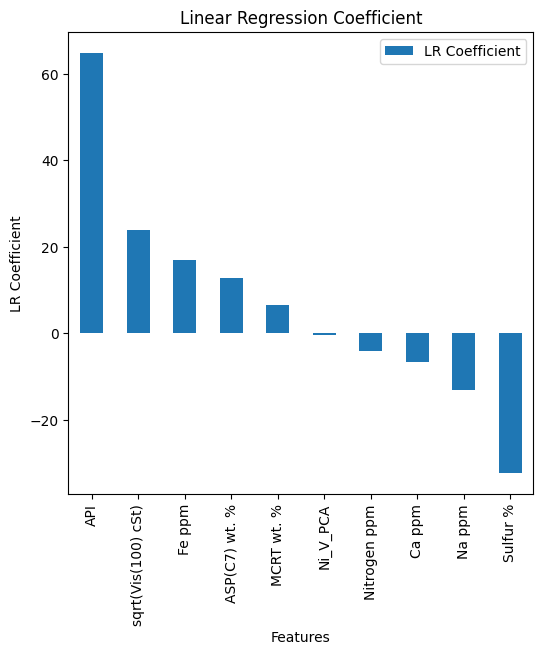

In [37]:
fi_df_lr_feed = pd.DataFrame({'features':x_scaled.columns[15:], 'LR_Coefficient':lr_importance[15:]})
fi_df_lr_feed.iloc[8, 0] = 'sqrt(Vis(100) cSt)'
fi_df_lr_feed_data = fi_df_lr_feed.sort_values(by='LR_Coefficient',ascending=False)

fig, ax = plt.subplots(figsize=(6, 6))

fi_df_lr_feed_data.plot(kind='bar', x='features', ax=ax)
# Add x and y labels
ax.set_xlabel('Features')  # x-axis label
ax.set_ylabel('LR Coefficient')  # y-axis label
ax.set_title('Linear Regression Coefficient') # Add a title

# Add a legend
ax.legend(['LR Coefficient'], loc='upper right')

plt.savefig("FI_LR.png", bbox_inches="tight")

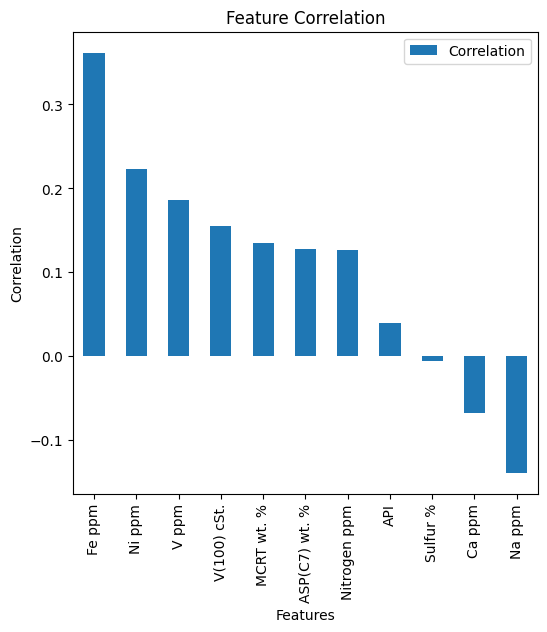

In [35]:
plt.figure(figsize=(6, 6))
corr_data = df.corr().drop(['SHFT_avg', 'vis100_sqrt'], axis=0)['SHFT_avg'][15:].sort_values(ascending=False)
ax = corr_data.plot(kind='bar')
# Add x and y labels
ax.set_xlabel('Features')  # x-axis label
ax.set_ylabel('Correlation')  # y-axis label

# Add a title
ax.set_title('Feature Correlation')

# Add a legend
ax.legend(['Correlation'], loc='upper right')

plt.savefig("Corr.png", bbox_inches="tight")

<Figure size 600x600 with 0 Axes>

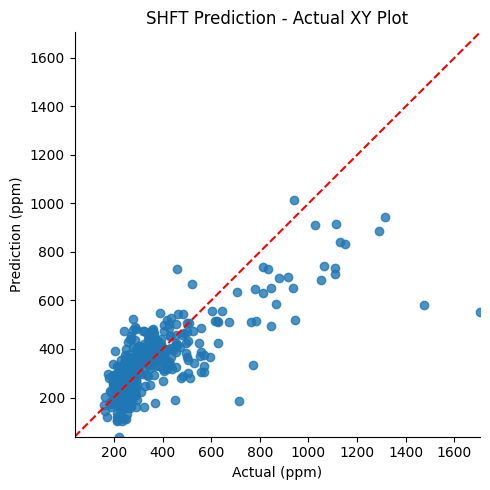

In [41]:
result_test_lr = {'Actual (ppm)':y_test, 'Prediction (ppm)': y_test_pred_lr}
y_plot_test_lr = pd.DataFrame(result_test_lr)

plt.figure(figsize=(6, 6))

sns.lmplot(data=y_plot_test_lr, x='Actual (ppm)', y='Prediction (ppm)', fit_reg=False)  
lims = [min(y_test.min(), y_test_pred_lr.min()), max(y_test.max(), y_test_pred_lr.max())]  # Limits for the line
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)

plt.title('SHFT Prediction - Actual XY Plot')
plt.tight_layout()

plt.savefig("pre_act.png")
plt.show()

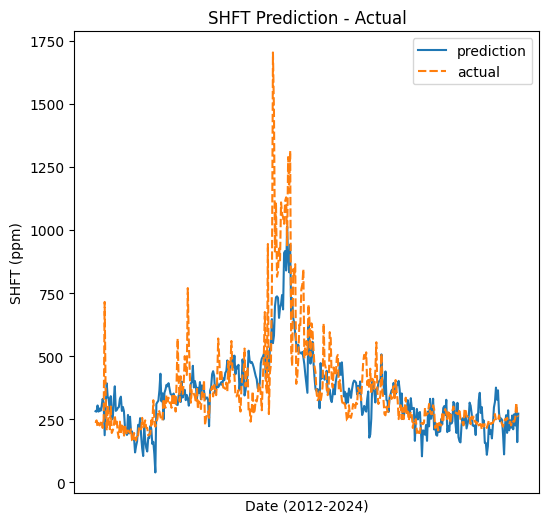

In [42]:
pred_actual_df_lr = pd.DataFrame({'prediction': y_test_pred_lr, 'actual':y_test})
plt.figure(figsize=(6, 6))
sns.lineplot(pred_actual_df_lr.sort_index())
plt.xticks([])
plt.xlabel('Date (2012-2024)')
plt.ylabel('SHFT (ppm)')
plt.title('SHFT Prediction - Actual')
plt.savefig("pre_act_trend.png")
plt.show()

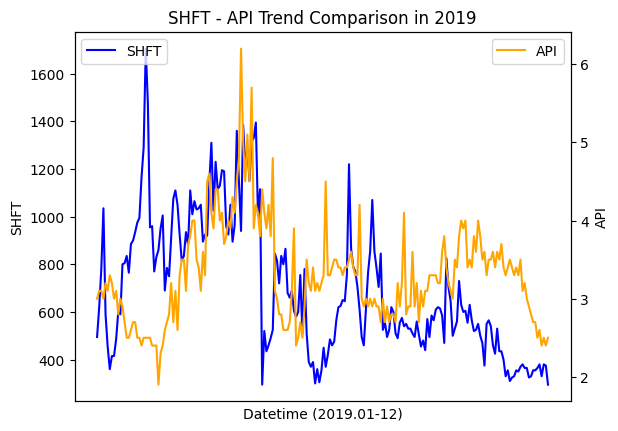

In [15]:
# 2019년 한정 API - SHFT 간 상당 부분 positively correlated 되어 있는 것으로 보임
data = df.loc['2019-01-01':'2020-01-01']
fig, ax1 = plt.subplots()
sns.lineplot(data=data, x=data.index, y='SHFT_avg', ax=ax1, label='SHFT', color='blue')

# Set up the second y-axis
ax2 = ax1.twinx()

# Plot the second variable
sns.lineplot(data=data, x=data.index, y='API', ax=ax2, label='API', color='orange')

# Labels
ax1.set_ylabel('SHFT')
ax2.set_ylabel('API')
ax1.set_xlabel('Datetime (2019.01-12)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xticks([])
plt.title('SHFT - API Trend Comparison in 2019')

plt.savefig("api_shft_2019.png")
plt.show()

In [16]:
# 2012-2018년 API - SHFT correlation
print('2012-2018년 API - SHFT correlation:', (df.loc[:'2019-01-01'].corr()['SHFT_avg']['API']).round(4))

# 2019년 API - SHFT correlation
print('2019년 API - SHFT correlation:', (df.loc['2019-01-01':'2020-01-01'].corr()['SHFT_avg']['API']).round(4))

# 2020-2024년 API - SHFT correlation
print('2020-2024년 API - SHFT correlation:', (df.loc['2020-01-01':].corr()['SHFT_avg']['API']).round(4))

# 2012-2024년 전체 API - SHFT correlation
print('2012-2024년 전체 기간 API - SHFT correlation:', (df.corr()['SHFT_avg']['API']).round(4))

2012-2018년 API - SHFT correlation: -0.3083
2019년 API - SHFT correlation: 0.2311
2020-2024년 API - SHFT correlation: -0.3403
2012-2024년 전체 기간 API - SHFT correlation: 0.0398


### XGB model (비교)

In [17]:
xgb = XGBRegressor(reg_alpha=0.1, reg_lambda=1, learning_rate=0.05, n_estimators = 200, max_depth=None, subsample=0.8, random_state=0)

# 1. cross validation을 통해 모델 성능 1차 확인
scores_xgb = cross_val_score(xgb, x_train, y_train, cv=kfold, scoring='r2', error_score='raise')
print("XGB Cross-Validation Scores:", scores_xgb)
print("XGB CV Average Score:", scores_xgb.mean())

# 2. cross validation 결과 만족
# -> cross validation 및 hyper parameter tuning(미수행)을 통해 얻은 모델을 바탕으로 validation set에 대한 성능 확인
xgb.fit(x_train, y_train)
y_val_pred_xgb = xgb.predict(x_val)
getScore('xgb_validation', y_val, y_val_pred_xgb)

# 3. validation set에 대한 성능 확인 결과 만족
# -> train+validation set으로 모델 학습한 뒤 test set에 대한 성능 최종 확인
xgb.fit(x_train_val, y_train_val)
y_test_pred_xgb = xgb.predict(x_test)
getScore('xgb_test', y_test, y_test_pred_xgb)

XGB Cross-Validation Scores: [0.7712237  0.83051572 0.66322771 0.88507535 0.8209884  0.85866755
 0.85188855 0.77969712 0.76382924 0.80436857]
XGB CV Average Score: 0.8029481907962603
xgb_validation, r2: 0.887, mape: 0.113, rmse: 61.170
xgb_test, r2: 0.848, mape: 0.105, rmse: 80.089


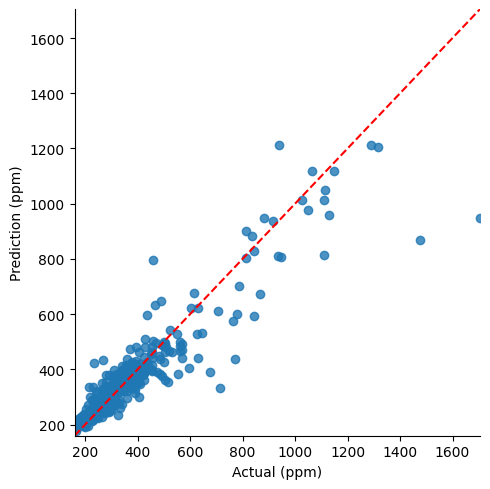

In [18]:
result_test_xgb = {'Actual (ppm)':y_test, 'Prediction (ppm)': y_test_pred_xgb}
y_plot_test_xgb = pd.DataFrame(result_test_xgb)
sns.lmplot(data=y_plot_test_xgb, x='Actual (ppm)', y='Prediction (ppm)', fit_reg=False)  
lims = [min(y_test.min(), y_test_pred_xgb.min()), max(y_test.max(), y_test_pred_xgb.max())]  # Limits for the line
plt.plot(lims, lims, 'r--')
plt.xlim(lims)
plt.ylim(lims)
plt.savefig("pre_act_xgb.png")
plt.show()

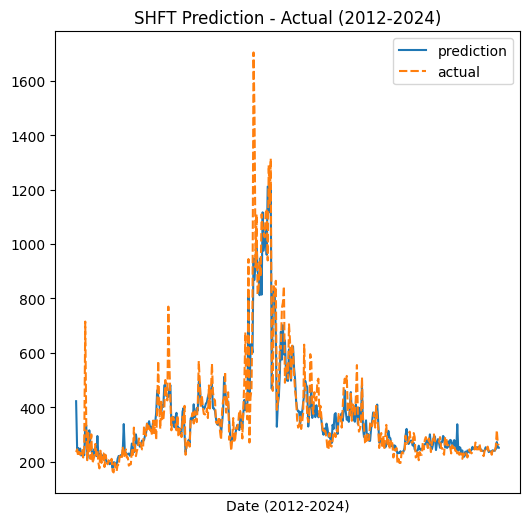

In [19]:
pred_actual_df_xgb = pd.DataFrame({'prediction': y_test_pred_xgb, 'actual':y_test})
plt.figure(figsize=(6, 6))
sns.lineplot(pred_actual_df_xgb.sort_index())
plt.xticks([])
plt.xlabel('Date (2012-2024)')
plt.title('SHFT Prediction - Actual (2012-2024)')
plt.savefig("pre_act_trend_xgb.png")
plt.show()